<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Supervised_Learning_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM Classifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# 1️⃣ Preprocessing the dataset
# ---------------------------

def preprocess_dataset_svm(df):
    """
    Preprocess the 26-class dataset specifically for SVM:
    - Remove columns where all values are zero
    - Normalize pixel values to [0,1]
    - Split into train/test sets (features and original string labels)
    """
    # Remove all-zero columns
    df_processed = df.loc[:, (df != 0).any(axis=0)].copy() # Use copy to avoid SettingWithCopyWarning

    # Separate features and labels
    labels = df_processed['labels']
    features_df = df_processed.drop(columns=['labels'])

    # Normalize pixel values to [0,1]
    # Ensure only numeric columns are selected for normalization
    numeric_cols = features_df.select_dtypes(include=np.number).columns.tolist()
    features_df[numeric_cols] = features_df[numeric_cols] / 255.0

    # Get feature values as numpy array
    X = features_df.values

    # Split data while preserving original string labels
    X_train, X_test, y_train_str, y_test_str = train_test_split(
        X, labels, test_size=0.3, stratify=labels, random_state=42
    )

    return X_train, X_test, y_train_str, y_test_str

# ---------------------------
# 2️⃣ SVM Exploration Function
# ---------------------------

def svm_explore(train_data, test_data, c1_str, c2_str):
    """
    Explore Linear, Polynomial, and RBF SVM classifiers for two classes.
    Expects train_data and test_data to be DataFrames including original string labels.
    Returns results dataframe and shows plots.
    """
    # Filter only the two classes using string labels
    train_subset = train_data[train_data['labels'].isin([c1_str, c2_str])].copy() # Use copy
    test_subset = test_data[test_data['labels'].isin([c1_str, c2_str])].copy() # Use copy


    # Encode labels for SVM (scikit-learn SVM requires numerical labels)
    label_encoder_subset = LabelEncoder()
    y_train = label_encoder_subset.fit_transform(train_subset['labels'])
    y_test = label_encoder_subset.transform(test_subset['labels'])

    X_train = train_subset.drop(columns=['labels']).values
    X_test = test_subset.drop(columns=['labels']).values


    results = []

    # --- Linear SVM ---
    linear_Cs = list(range(5, 51, 5))
    linear_train_acc, linear_test_acc = [], []
    for C in linear_Cs:
        clf = SVC(kernel='linear', C=C, max_iter=10000) # Increased max_iter
        try:
          clf.fit(X_train, y_train)
          train_acc = accuracy_score(y_train, clf.predict(X_train))
          test_acc = accuracy_score(y_test, clf.predict(X_test))
          n_sv = len(clf.support_)
          results.append([f'Linear/C={C}', n_sv, train_acc, test_acc])
          linear_train_acc.append(train_acc)
          linear_test_acc.append(test_acc)
        except Exception as e:
          print(f"Error training Linear SVM with C={C}: {e}")
          # Append placeholder values to keep list lengths consistent for plotting
          results.append([f'Linear/C={C}', 0, np.nan, np.nan])
          linear_train_acc.append(np.nan)
          linear_test_acc.append(np.nan)


    # --- Polynomial SVM ---
    poly_degrees = [2, 3, 4, 5]
    poly_train_acc, poly_test_acc = [], []
    for d in poly_degrees:
        clf = SVC(kernel='poly', degree=d, C=1, max_iter=10000) # Increased max_iter
        try:
          clf.fit(X_train, y_train)
          train_acc = accuracy_score(y_train, clf.predict(X_train))
          test_acc = accuracy_score(y_test, clf.predict(X_test))
          n_sv = len(clf.support_)
          results.append([f'Poly/d={d}', n_sv, train_acc, test_acc])
          poly_train_acc.append(train_acc)
          poly_test_acc.append(test_acc)
        except Exception as e:
           print(f"Error training Poly SVM with degree={d}: {e}")
           results.append([f'Poly/d={d}', 0, np.nan, np.nan])
           poly_train_acc.append(np.nan)
           poly_test_acc.append(np.nan)


    # --- RBF SVM ---
    rbf_sigmas = list(range(2, 11, 2))
    rbf_train_acc, rbf_test_acc = [], []
    for sigma in rbf_sigmas:
        gamma = 1 / (2 * sigma**2)
        clf = SVC(kernel='rbf', gamma=gamma, C=1, max_iter=10000) # Increased max_iter
        try:
          clf.fit(X_train, y_train)
          train_acc = accuracy_score(y_train, clf.predict(X_train))
          test_acc = accuracy_score(y_test, clf.predict(X_test))
          n_sv = len(clf.support_)
          results.append([f'RBF/sigma={sigma}', n_sv, train_acc, test_acc])
          rbf_train_acc.append(train_acc)
          rbf_test_acc.append(test_acc)
        except Exception as e:
           print(f"Error training RBF SVM with sigma={sigma}: {e}")
           results.append([f'RBF/sigma={sigma}', 0, np.nan, np.nan])
           rbf_train_acc.append(np.nan)
           rbf_test_acc.append(np.nan)


    # --- Save results ---
    results_df = pd.DataFrame(results, columns=['Classifier', 'Num_Support_Vectors', 'Train_Acc', 'Test_Acc'])
    # Filter out rows with NaN accuracies before saving/printing table if preferred, or handle in plotting
    results_df_cleaned = results_df.dropna(subset=['Train_Acc', 'Test_Acc']).copy()
    if not results_df_cleaned.empty:
        # Save using string labels for the filename as originally intended
        results_df_cleaned.to_csv(f'/content/svm_results_{c1_str}_{c2_str}.csv', index=False)
        print(f"\n=== SVM Results Table for classes {c1_str} and {c2_str} ===")
        print(results_df_cleaned.to_string(index=False))
    else:
        print(f"\n=== SVM Results Table for classes {c1_str} and {c2_str} ===")
        print("No successful SVM model training for these classes.")


    # --- Plot Accuracies vs Complexity ---
    # Need to filter NaN values for plotting
    plot_results_df = results_df.dropna(subset=['Train_Acc', 'Test_Acc'])

    plt.figure(figsize=(15, 4))

    # Linear Plot
    linear_plot_data = plot_results_df[plot_results_df['Classifier'].str.startswith('Linear')]
    if not linear_plot_data.empty:
        linear_Cs_plot = [int(s.split('=')[1]) for s in linear_plot_data['Classifier']]
        plt.subplot(1, 3, 1)
        plt.plot(linear_Cs_plot, linear_plot_data['Train_Acc'], 'o-', label='Train Acc')
        plt.plot(linear_Cs_plot, linear_plot_data['Test_Acc'], 's-', label='Test Acc')
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.title(f'Linear SVM Accuracy ({c1_str} vs {c2_str})')
        plt.legend()
        plt.grid(True)
    else:
         plt.subplot(1, 3, 1)
         plt.title(f'Linear SVM Accuracy ({c1_str} vs {c2_str})\nNo successful runs')


    # Polynomial Plot
    poly_plot_data = plot_results_df[plot_results_df['Classifier'].str.startswith('Poly')]
    if not poly_plot_data.empty:
        poly_degrees_plot = [int(s.split('=')[1]) for s in poly_plot_data['Classifier']]
        plt.subplot(1, 3, 2)
        plt.plot(poly_degrees_plot, poly_plot_data['Train_Acc'], 'o-', label='Train Acc')
        plt.plot(poly_degrees_plot, poly_test_acc, 's-', label='Test Acc')
        plt.xlabel('Degree')
        plt.ylabel('Accuracy')
        plt.title(f'Polynomial SVM Accuracy ({c1_str} vs {c2_str})')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 3, 2)
        plt.title(f'Polynomial SVM Accuracy ({c1_str} vs {c2_str})\nNo successful runs')


    # RBF Plot
    rbf_plot_data = plot_results_df[plot_results_df['Classifier'].str.startswith('RBF')]
    if not rbf_plot_data.empty:
        rbf_sigmas_plot = [int(s.split('=')[1]) for s in rbf_plot_data['Classifier']]
        plt.subplot(1, 3, 3)
        plt.plot(rbf_sigmas_plot, rbf_plot_data['Train_Acc'], 'o-', label='Train Acc')
        plt.plot(rbf_sigmas_plot, rbf_plot_data['Test_Acc'], 's-', label='Test Acc')
        plt.xlabel('Sigma')
        plt.ylabel('Accuracy')
        plt.title(f'RBF SVM Accuracy ({c1_str} vs {c2_str})')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 3, 3)
        plt.title(f'RBF SVM Accuracy ({c1_str} vs {c2_str})\nNo successful runs')


    plt.tight_layout()
    plt.show()

    # --- Scatter plot Support Vectors vs Train Acc ---
    if not plot_results_df.empty:
        plt.figure(figsize=(6, 5))
        plt.scatter(plot_results_df['Num_Support_Vectors'], plot_results_df['Train_Acc'], c='blue')
        plt.xlabel('Number of Support Vectors')
        plt.ylabel('Training Accuracy')
        plt.title(f'Support Vectors vs Training Accuracy ({c1_str} vs {c2_str})')
        plt.grid(True)
        plt.show()
    else:
         print("No data to plot Support Vectors vs Training Accuracy.")

    # --- Trend Analysis ---
    print("\n--- Trend Analysis ---")
    if not plot_results_df.empty:
        def analyze(train_acc, test_acc, name):
            if max(train_acc) - min(train_acc) > 0.05:
                print(f"{name}: Training accuracy rises with complexity.")
            if max(train_acc) > max(test_acc) + 0.05:
                print(f"{name}: Possible overfitting (train > test).")
            if max(test_acc) - min(test_acc) < 0.05:
                print(f"{name}: Test accuracy is stable, model generalizes well.")

        # Analyze only models that trained successfully
        linear_trained = plot_results_df[plot_results_df['Classifier'].str.startswith('Linear')]
        if not linear_trained.empty:
             analyze(linear_trained['Train_Acc'], linear_trained['Test_Acc'], "Linear SVM")

        poly_trained = plot_results_df[plot_results_df['Classifier'].str.startswith('Poly')]
        if not poly_trained.empty:
             analyze(poly_trained['Train_Acc'], poly_trained['Test_Acc'], "Polynomial SVM")

        rbf_trained = plot_results_df[plot_results_df['Classifier'].str.startswith('RBF')]
        if not rbf_trained.empty:
             analyze(rbf_trained['Train_Acc'], rbf_trained['Test_Acc'], "RBF SVM")


        corr = plot_results_df['Num_Support_Vectors'].corr(plot_results_df['Train_Acc'])
        if pd.notna(corr): # Check if correlation is not NaN
             if corr > 0.2:
                 print("Support Vectors vs Training Accuracy: Positive correlation (more SVs -> higher train acc).")
             else:
                 print("Support Vectors vs Training Accuracy: No strong correlation.")
        else:
             print("Support Vectors vs Training Accuracy: Cannot calculate correlation (no successful runs).")

    else:
        print("No data available for trend analysis.")


    return results_df_cleaned # Return the cleaned DataFrame with successful runs

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con


=== SVM Results Table for classes A and B ===
  Classifier  Num_Support_Vectors  Train_Acc  Test_Acc
  Linear/C=5                 2670   0.530392  0.486166
 Linear/C=10                 2601   0.562001  0.537549
 Linear/C=15                 2592   0.510594  0.503953
 Linear/C=20                 2570   0.514415  0.515810
 Linear/C=25                 2580   0.510941  0.503953
 Linear/C=30                 2563   0.547412  0.492095
 Linear/C=35                 2579   0.530392  0.505929
 Linear/C=40                 2527   0.531087  0.466403
 Linear/C=45                 2552   0.520320  0.521739
 Linear/C=50                 2543   0.520667  0.507905
    Poly/d=2                 2752   0.692254  0.490119
    Poly/d=3                 2716   0.767975  0.492095
    Poly/d=4                 2671   0.813130  0.472332
    Poly/d=5                 2641   0.837444  0.460474
 RBF/sigma=2                 2865   0.972560  0.474308
 RBF/sigma=4                 2813   0.821466  0.474308
 RBF/sigma=6      

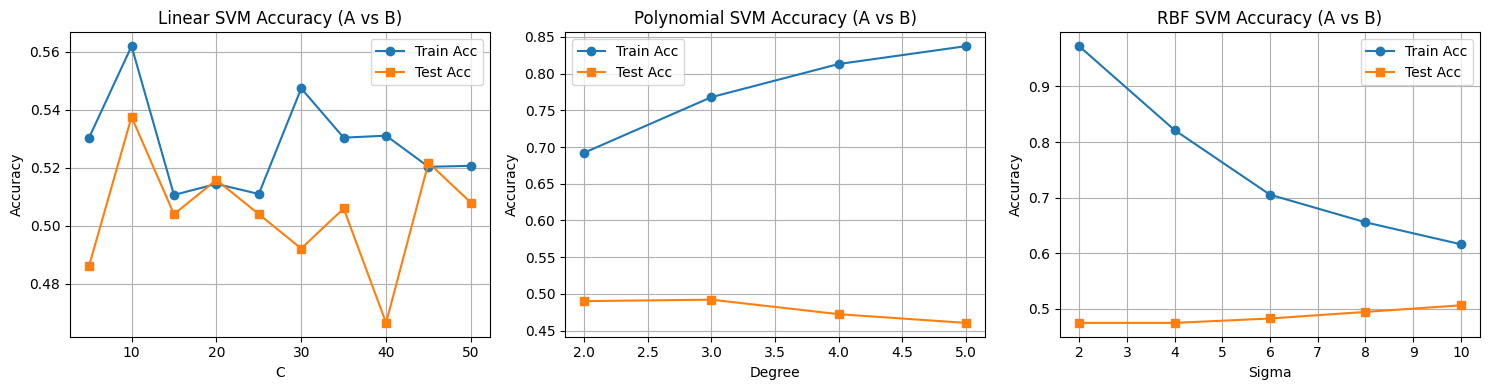

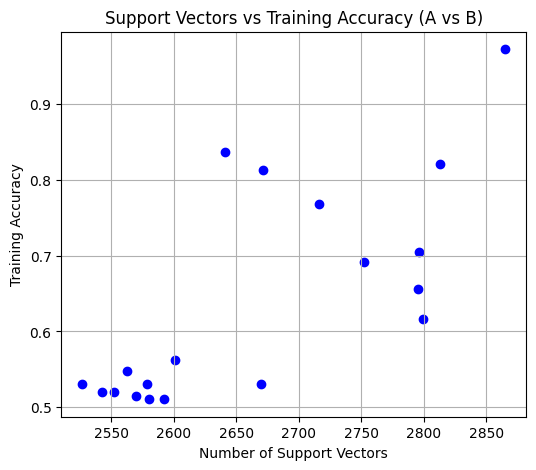


--- Trend Analysis ---
Linear SVM: Training accuracy rises with complexity.
Polynomial SVM: Training accuracy rises with complexity.
Polynomial SVM: Possible overfitting (train > test).
Polynomial SVM: Test accuracy is stable, model generalizes well.
RBF SVM: Training accuracy rises with complexity.
RBF SVM: Possible overfitting (train > test).
RBF SVM: Test accuracy is stable, model generalizes well.
Support Vectors vs Training Accuracy: Positive correlation (more SVs -> higher train acc).

Results for classes A and B:


,Classifier,Num_Support_Vectors,Train_Acc,Test_Acc
0,Linear/C=5,2670,0.530392,0.486166
1,Linear/C=10,2601,0.562001,0.537549
2,Linear/C=15,2592,0.510594,0.503953
3,Linear/C=20,2570,0.514415,0.515810
4,Linear/C=25,2580,0.510941,0.503953
5,Linear/C=30,2563,0.547412,0.492095
6,Linear/C=35,2579,0.530392,0.505929
7,Linear/C=40,2527,0.531087,0.466403
8,Linear/C=45,2552,0.520320,0.521739
9,Linear/C=50,2543,0.520667,0.507905


In [ ]:
# Assuming df and label_encoder are already defined from previous cells

# Preprocess the dataset using the updated function
X_train_svm, X_test_svm, y_train_str_svm, y_test_str_svm = preprocess_dataset_svm(df.copy())

# Construct DataFrames for svm_explore with original string labels
train_df_svm = pd.DataFrame(X_train_svm)
train_df_svm['labels'] = y_train_str_svm

test_df_svm = pd.DataFrame(X_test_svm)
test_df_svm['labels'] = y_test_str_svm


# Run SVM exploration for classes 'A' and 'B' using string labels
# You can change 'A' and 'B' to any two class labels from your dataset
results_A_B_svm = svm_explore(train_df_svm, test_df_svm, c1_str='A', c2_str='B')

# Display the results table
print("\nResults for classes A and B:")
display(results_A_B_svm)

Recommendations:


1.   Linear, Ploynomial and RBF SVMs are plotted between two classes A and B
2.   Train accuracy will improve with complexity for Linear SVM
3.   Training accuracy is good and also overfitting for Polynomial SVM (test > train)
4.   Training accuracy is good and also overfitting for RBF SVM (test > train)
5.   From support vector vs training accuracy plot it is clear that as the number of support vectors increases the accuracy also increases.
6.   Scatter Plot shows a positive correlation.

